In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
from scipy.optimize import curve_fit
import markdown
import sys
sys.path.append('/Users/vs522/Dropbox/Python')
sys.path.append('/Users/vs522/Dropbox/Python/gloess')

from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import astropy.units as u
import seaborn as sns
import os
import glob
import linecache
import gloess_fits as gf
import re
from IPython.display import Image
import itertools
import reddening_laws as red
from astropy.stats import sigma_clip
import scipy.optimize as op
import emcee
import corner
from matplotlib.ticker import MaxNLocator
from astroquery.irsa_dust import IrsaDust
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap






bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
mp.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

In [46]:
gaia_df = pd.read_csv('dr1_crossmatch.tsv', skiprows=166, skipinitialspace=True, names=('input', 'rad', 'HIP', 'TYC2', 'SolID', 'Source', 'RandomI', 'Epoch', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RADEcor', 'RAPlxcor', 'RApmRAcor', 'RApmDEcor', 'DEPlxcor', 'DEpmRAcor', 'DEpmDEcor', 'PlxpmRAcor', 'PlxpmDEcor', 'pmRApmDEcor', 'NAL', 'NAC', 'NgAL', 'NgAC', 'NbAL', 'NbAC', 'DQ', 'epsi', 'sepsi', 'APF', 'ARF', 'WAL', 'WAC', 'Apr', 'MatchObs', 'Dup', 'sK1', 'sK2', 'sK3', 'sK4', 'mK1', 'mK2', 'mK3', 'mK4', 'o_<Gmag>', '<FG>', 'e_<FG>', '<Gmag>', 'Var', 'GLON', 'GLAT', 'ELON', 'ELAT'), na_values='NOT_AVAILABLE', sep=';', comment='#')
gaia_df['ID'] = gaia_df.input.str.split('\t',0).str.get(0)

gaia_df = gaia_df.drop('input', 1)
#gaia_df = gaia_df.drop('rad', 1)
gaia_df = gaia_df.replace('', np.nan)
gaia_df['ID'] = gaia_df['ID'].replace(regex=True, to_replace=r' ',value='_')
gaia_df['id_compare'] = gaia_df['ID'].str.lower()
gaia_df['id_compare'] = gaia_df['id_compare'].replace(regex=True, to_replace=r'_',value='')

In [47]:
gaia_df.id_compare

0       abuma
1       amtuc
2       anser
3       avpeg
4       bhpeg
5       bxleo
6       cseri
7       dxdel
8       hkpup
9       mttel
10      rrgem
11      rrgem
12      rrgem
13      rrlyr
14      rupsc
15      rvcrb
16      rvuma
17      rxeri
18      rxeri
19      rzcep
20      rzcep
21      stboo
22      stcvn
23      sudra
24      sveri
25      svhya
26      svscl
27      swand
28      swdra
29      sxuma
30      ttlyn
31      tuuma
32      tvboo
33      twher
34      uuvir
35      uuvir
36      uvoct
37      uyboo
38    v440sgr
39      vxher
40       vind
41       vind
42      wyant
43      xzcyg
44       xari
45      yzcap
Name: id_compare, dtype: object

# Testing the ABL method to compare to Astramada & Bailer Jones parallaxes/distances

Using the equations on P11 of Murareva et al. 2018

$$ ABL = 10^{0.2M} = 10^{0.2(\alpha \log P + \beta)} = \varpi 10^{0.2 m_0 - 2} $$ 

where $M$ is the absolute mag, $P$ is the period, $m_0$ is the apparent mag, and $\alpha$ is the slope of the PL relation.

In [48]:
info_df = pd.read_csv('rrl_average_mags', delim_whitespace=True)
info_df

,Name,Period,Type,id_compare,mag_3p6,err_3p6,amp_3p6,mag_4p5,err_4p5,amp_4p5
0,ABUma,0.600,ab,abuma,9.598,0.003,0.171,9.587,0.003,0.177
1,AMTuc,0.406,c,amtuc,10.602,0.002,0.127,10.565,0.002,0.142
2,ANSer,0.522,ab,anser,9.801,0.004,0.289,9.795,0.004,0.299
3,APSer,0.341,c,apser,10.213,0.002,0.111,10.202,0.002,0.122
4,AVPeg,0.390,ab,avpeg,9.332,0.004,0.281,9.329,0.004,0.281
5,BHPeg,0.641,ab,bhpeg,9.002,0.003,0.237,8.982,0.003,0.236
6,BXLeo,0.363,c,bxleo,10.678,0.002,0.107,10.670,0.002,0.122
7,CSEri,0.311,c,cseri,8.126,0.002,0.117,8.110,0.002,0.117
8,CUCom,0.406,d,cucom,12.258,0.002,0.142,12.229,0.002,0.211
9,DHPeg,0.256,c,dhpeg,8.610,0.004,0.305,8.662,0.008,0.852


In [49]:
printcols = ['ID', 'rad']
gaia_df[printcols]
gaia_df = gaia_df.groupby(['ID']).min()


In [50]:
gaia_df.columns

Index(['rad', 'HIP', 'SolID', 'Source', 'RandomI', 'Epoch', 'RA_ICRS',
       'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA',
       'pmDE', 'e_pmDE', 'RADEcor', 'RAPlxcor', 'RApmRAcor', 'RApmDEcor',
       'DEPlxcor', 'DEpmRAcor', 'DEpmDEcor', 'PlxpmRAcor', 'PlxpmDEcor',
       'pmRApmDEcor', 'NAL', 'NAC', 'NgAL', 'NgAC', 'NbAL', 'NbAC', 'DQ',
       'epsi', 'sepsi', 'APF', 'ARF', 'WAL', 'WAC', 'Apr', 'MatchObs', 'Dup',
       'sK1', 'sK2', 'sK3', 'sK4', 'mK1', 'mK2', 'mK3', 'mK4', 'o_<Gmag>',
       '<FG>', 'e_<FG>', '<Gmag>', 'Var', 'GLON', 'GLAT', 'ELON', 'ELAT',
       'id_compare'],
      dtype='object')

In [51]:
merged_df = info_df.merge(gaia_df, on='id_compare')
useful = ['Name', 'Period', 'Type', 'mag_3p6', 'err_3p6', 'amp_3p6', 'mag_4p5', 'err_4p5', 'amp_4p5', 'RA_ICRS', 'DE_ICRS', 'Plx', 'e_Plx', 'id_compare']
analysis_df = merged_df[useful]
analysis_df = analysis_df.reset_index(drop=True)
analysis_df

,Name,Period,Type,mag_3p6,err_3p6,amp_3p6,mag_4p5,err_4p5,amp_4p5,RA_ICRS,DE_ICRS,Plx,e_Plx,id_compare
0,ABUma,0.600,ab,9.598,0.003,0.171,9.587,0.003,0.177,182.810685,47.828763,0.93,0.27,abuma
1,AMTuc,0.406,c,10.602,0.002,0.127,10.565,0.002,0.142,19.627973,-67.918161,0.85,0.26,amtuc
2,ANSer,0.522,ab,9.801,0.004,0.289,9.795,0.004,0.299,238.379390,12.961105,0.77,0.29,anser
3,AVPeg,0.390,ab,9.332,0.004,0.281,9.329,0.004,0.281,328.011708,22.574791,1.53,0.23,avpeg
4,BHPeg,0.641,ab,9.002,0.003,0.237,8.982,0.003,0.236,343.254215,15.787682,1.40,0.22,bhpeg
5,BXLeo,0.363,c,10.678,0.002,0.107,10.670,0.002,0.122,174.508478,16.543330,0.53,0.28,bxleo
6,CSEri,0.311,c,8.126,0.002,0.117,8.110,0.002,0.117,39.274539,-42.963311,2.16,0.23,cseri
7,DXDel,0.473,ab,8.653,0.004,0.249,8.641,0.004,0.258,311.868205,12.464108,1.66,0.22,dxdel
8,HKPup,0.734,ab,9.884,0.004,0.252,9.854,0.004,0.257,116.195095,-13.098978,0.53,0.26,hkpup
9,MTTel,0.317,c,8.078,0.002,0.126,8.064,0.002,0.111,285.550322,-46.653841,1.43,0.31,mttel


In [52]:
def grab_extinction(row):
    star = row.Name
    ra = row.RA_ICRS
    dec = row.DE_ICRS
    coord_string = str(ra) + 'd ' +  str(dec) + 'd'
    C = coord.SkyCoord(coord_string, frame='fk5')
    table = IrsaDust.get_extinction_table(C)
    irac_1_sandf = table[19][3]
    irac_2_sandf = table[20][3]
    analysis_df.ix[analysis_df.Name==star, 'A_3p6'] = irac_1_sandf
    analysis_df.ix[analysis_df.Name==star, 'A_4p5'] = irac_2_sandf
    print (star, irac_1_sandf, irac_2_sandf)
    return(0)
    

In [53]:
analysis_df.apply(lambda line: grab_extinction(line), axis=1);

/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


ABUma 0.005 0.004
AMTuc 0.004 0.004
ANSer 0.007 0.006
AVPeg 0.013 0.011
BHPeg 0.015 0.012
BXLeo 0.005 0.004
CSEri 0.004 0.003
DXDel 0.024 0.02
HKPup 0.064 0.053
MTTel 0.011 0.009
RRGem 0.012 0.01
RRLyr 0.018 0.015
RUPsc 0.008 0.007
RvCrB 0.008 0.006
RVUma 0.003 0.003
RXEri 0.012 0.01
RZCep 0.187 0.155
STBoo 0.004 0.003
STCVn 0.003 0.002
SUDra 0.002 0.001
SVEri 0.016 0.014
SVHya 0.015 0.013
SVScl 0.003 0.002
SWAnd 0.008 0.007
SWDra 0.003 0.002
SXUma 0.002 0.002
TTLyn 0.003 0.003
TUUma 0.004 0.003
TVBoo 0.002 0.001
TWHer 0.008 0.006
UUVir 0.003 0.003
UVOct 0.018 0.015
UYBoo 0.007 0.006
V440Sgr 0.017 0.014
VXHer 0.009 0.007
VInd 0.009 0.007
WYAnt 0.012 0.01
XZCyg 0.023 0.019
XAri 0.037 0.031
YZCap 0.012 0.01


In [54]:
## abl_mags

analysis_df['abl_mag_3p6'] = analysis_df.Plx*10**(0.2*(analysis_df.mag_3p6- analysis_df.A_3p6) - 2.0)
analysis_df['abl_mag_4p5'] = analysis_df.Plx*10**(0.2*(analysis_df.mag_3p6- analysis_df.A_4p5) - 2.0) 

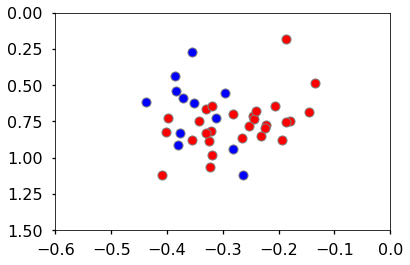

In [55]:
mp.plot(np.log10(analysis_df.ix[analysis_df.Type=='ab', 'Period']), analysis_df.ix[analysis_df.Type=='ab', 'abl_mag_3p6'], 'o', color='red', ls='None', zorder=4, markeredgecolor='Grey', markeredgewidth=1, label='RRab')

mp.xlim(-0.6, 0)
mp.ylim(1.5, 0.0)

mp.plot(np.log10(analysis_df.ix[analysis_df.Type=='c', 'Period']) + 0.127, analysis_df.ix[analysis_df.Type=='c', 'abl_mag_3p6'], 'o', color='blue', ls='None', zorder=4, markeredgecolor='Grey', markeredgewidth=1, label='RRc')


In [56]:
analysis_df

,Name,Period,Type,mag_3p6,err_3p6,amp_3p6,mag_4p5,err_4p5,amp_4p5,RA_ICRS,DE_ICRS,Plx,e_Plx,id_compare,A_3p6,A_4p5,abl_mag_3p6,abl_mag_4p5
0,ABUma,0.600,ab,9.598,0.003,0.171,9.587,0.003,0.177,182.810685,47.828763,0.93,0.27,abuma,0.005,0.004,0.771051,0.771406
1,AMTuc,0.406,c,10.602,0.002,0.127,10.565,0.002,0.142,19.627973,-67.918161,0.85,0.26,amtuc,0.004,0.004,1.119487,1.119487
2,ANSer,0.522,ab,9.801,0.004,0.289,9.795,0.004,0.299,238.379390,12.961105,0.77,0.29,anser,0.007,0.006,0.700311,0.700633
3,AVPeg,0.390,ab,9.332,0.004,0.281,9.329,0.004,0.281,328.011708,22.574791,1.53,0.23,avpeg,0.013,0.011,1.118128,1.119158
4,BHPeg,0.641,ab,9.002,0.003,0.237,8.982,0.003,0.236,343.254215,15.787682,1.40,0.22,bhpeg,0.015,0.012,0.878068,0.879282
5,BXLeo,0.363,c,10.678,0.002,0.107,10.670,0.002,0.122,174.508478,16.543330,0.53,0.28,bxleo,0.005,0.004,0.722563,0.722896
6,CSEri,0.311,c,8.126,0.002,0.117,8.110,0.002,0.117,39.274539,-42.963311,2.16,0.23,cseri,0.004,0.003,0.909607,0.910026
7,DXDel,0.473,ab,8.653,0.004,0.249,8.641,0.004,0.258,311.868205,12.464108,1.66,0.22,dxdel,0.024,0.020,0.882893,0.884521
8,HKPup,0.734,ab,9.884,0.004,0.252,9.854,0.004,0.257,116.195095,-13.098978,0.53,0.26,hkpup,0.064,0.053,0.487838,0.490316
9,MTTel,0.317,c,8.078,0.002,0.126,8.064,0.002,0.111,285.550322,-46.653841,1.43,0.31,mttel,0.011,0.009,0.587132,0.587673


In [57]:
def pl_fit_simple(x, zp):
    return -2.276*x + zp

In [58]:
popt, pcov = curve_fit(pl_fit_simple, np.log10(analysis_df.ix[analysis_df.Type=='ab', 'Period']),analysis_df.ix[analysis_df.Type=='ab', 'abl_mag_3p6'], sigma=analysis_df.ix[analysis_df.Type=='ab', 'err_3p6'], absolute_sigma=True)

In [59]:
popt, pcov
zp = popt[0]
zp

0.15561526937945591

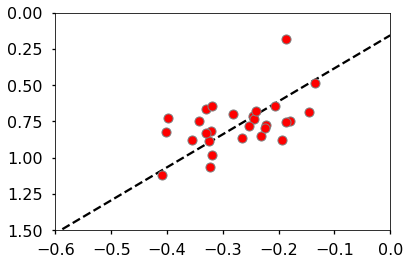

In [60]:
mp.plot(np.log10(analysis_df.ix[analysis_df.Type=='ab', 'Period']), analysis_df.ix[analysis_df.Type=='ab', 'abl_mag_3p6'], 'o', color='red', ls='None', zorder=4, markeredgecolor='Grey', markeredgewidth=1, label='RRab')

mp.xlim(-0.6, 0)
mp.ylim(1.5, 0.0)

p1 = np.arange(-1,0.1,0.1)
mp.plot(p1, -2.276*p1 + zp, ls='--', label="RRab fit", color='black')


In [61]:
var_ab = np.sum(analysis_df.ix[analysis_df.Type=='ab', 'abl_mag_3p6'] - (-2.276*np.log10(analysis_df.ix[analysis_df.Type=='ab', 'Period']) + zp)**2) / (len(analysis_df.ix[analysis_df.Type=='ab', 'abl_mag_3p6']))
sd_ab = np.sqrt(var_ab)

In [62]:
sd_ab

0.36869672772212941

In [63]:
np.sum(analysis_df.ix[analysis_df.Type=='ab', 'abl_mag_3p6'])

21.436157905932681

In [64]:
import os
from astropy.io import ascii


In [65]:
mw_data = ascii.read('MW_Ceph_targets', format='ipac')
lmc_data = ascii.read('LMC_Ceph_targets', format='ipac')
smc_data = ascii.read('SMC_Ceph_targets', format='ipac')

In [66]:
mw_data

Target_name,RA,Dec,NAIF_ID,Instrument/Mode,AORKEY,AOR_label,Observation_start_time,Observation_end_time,Program_ID,PI
str8,float64,float64,int64,str11,int64,str28,str19,str19,int64,str15
Zeta_Gem,106.02708,20.57027,--,IRAC Map PC,36131584,MW Ceph - Zeta_Gem - epoch 3,2010-11-25 09:10:32,2010-11-25 09:17:02,60010,"Freedman, Wendy"
DL_Cas,7.49375,60.21194,--,IRAC Map PC,36220928,MW Ceph - DL_Cas - epoch 3,2010-09-13 06:33:50,2010-09-13 06:38:23,60010,"Freedman, Wendy"
X_Cyg,310.85083,35.58777,--,IRAC Map PC,36095488,MW Ceph - X_Cyg - epoch 3,2009-11-21 05:29:17,2009-11-21 05:34:24,60010,"Freedman, Wendy"
T_Vul,312.8675,28.25055,--,IRAC Map PC,36164608,MW Ceph - T_Vul - epoch 3,2009-11-24 13:14:55,2009-11-24 13:20:36,60010,"Freedman, Wendy"
u_car,164.45083,-59.73222,--,IRAC Map PC,36081920,MW Ceph - u_car - epoch 3,2010-07-02 07:58:56,2010-07-02 08:14:23,60010,"Freedman, Wendy"
U_Aql,292.33875,-7.04416,--,IRAC Map PC,36030720,MW Ceph - U_Aql - epoch 3,2009-11-01 09:00:58,2009-11-01 09:06:25,60010,"Freedman, Wendy"
s_vul,297.09916,27.28638,--,IRAC Map PC,36084992,MW Ceph - s_vul - epoch 3,2009-11-03 18:34:50,2009-11-03 18:41:24,60010,"Freedman, Wendy"
tt_aql,287.05708,1.29861,--,IRAC Map PC,36122368,MW Ceph - tt_aql - epoch 3,2009-10-26 01:30:07,2009-10-26 01:37:22,60010,"Freedman, Wendy"
Del_Cep,337.2925,58.41527,--,IRAC Map PC,36126976,MW Ceph - Del_Cep - epoch 3,2009-11-01 09:06:25,2009-11-01 09:16:53,60010,"Freedman, Wendy"


In [67]:
lmc_data

Target_name,RA,Dec,NAIF_ID,Instrument/Mode,AORKEY,AOR_label,Observation_start_time,Observation_end_time,Program_ID,PI
str7,float64,float64,int64,str11,int64,str18,str19,str19,int64,str15
HV02270,75.2,-69.531389,--,IRAC Map PC,32018432,LMC HV02270 epoch3,2009-10-04 04:40:18,2009-10-04 04:43:42,61000,"Freedman, Wendy"
HV02579,82.316667,-67.473333,--,IRAC Map PC,32052992,LMC HV02579 epoch3,2009-10-04 04:36:48,2009-10-04 04:40:18,61000,"Freedman, Wendy"
HV00887,75.541667,-69.539722,--,IRAC Map PC,32064000,LMC HV00887 epoch3,2009-10-04 05:22:23,2009-10-04 05:25:26,61000,"Freedman, Wendy"
HV00911,77.645833,-69.138056,--,IRAC Map PC,32106496,LMC HV00911 epoch3,2009-10-04 05:10:15,2009-10-04 05:13:11,61004,"Freedman, Wendy"
HV02244,74.458333,-67.839167,--,IRAC Map PC,32108800,LMC HV02244 epoch3,2009-10-04 05:03:34,2009-10-04 05:06:57,61004,"Freedman, Wendy"
HV12724,71.504167,-69.648056,--,IRAC Map PC,32113408,LMC HV12724 epoch3,2009-10-04 04:50:00,2009-10-04 04:53:41,61004,"Freedman, Wendy"
HV00932,79.808333,-69.604722,--,IRAC Map PC,32122624,LMC HV00932 epoch3,2009-10-04 04:30:13,2009-10-04 04:33:23,61004,"Freedman, Wendy"
HV01019,85.7125,-70.136944,--,IRAC Map PC,32150272,LMC HV01019 epoch3,2009-10-04 04:46:40,2009-10-04 04:50:00,61004,"Freedman, Wendy"
HV00997,83.254167,-68.190833,--,IRAC Map PC,32158208,LMC HV00997 epoch3,2009-10-04 04:26:52,2009-10-04 04:30:13,61004,"Freedman, Wendy"


In [68]:
smc_data

Target_name,RA,Dec,NAIF_ID,Instrument/Mode,AORKEY,AOR_label,Observation_start_time,Observation_end_time,Program_ID,PI
str7,float64,float64,int64,str11,int64,str18,str19,str19,int64,str15
HV00817,9.81875,-72.033056,--,IRAC Map PC,39563008,SMC HV00817 epoch3,2010-08-29 17:04:01,2010-08-29 17:07:10,70010,"Madore, Barry F"
HV00819,9.81875,-72.033056,--,IRAC Map PC,39569152,SMC HV00819 epoch3,2010-08-30 22:58:06,2010-08-30 23:01:04,70010,"Madore, Barry F"
HV00822,9.81875,-72.033056,--,IRAC Map PC,39575296,SMC HV00822 epoch3,2010-08-29 16:41:11,2010-08-29 16:44:33,70010,"Madore, Barry F"
HV00823,9.81875,-72.033056,--,IRAC Map PC,39578368,SMC HV00823 epoch3,2010-08-31 19:52:51,2010-08-31 19:55:59,70010,"Madore, Barry F"
HV00824,11.722083,-72.714167,--,IRAC Map PC,39581440,SMC HV00824 epoch3,2010-09-05 19:21:07,2010-09-05 19:24:05,70010,"Madore, Barry F"
HV00829,12.620833,-72.7525,--,IRAC Map PC,39587584,SMC HV00829 epoch3,2010-09-09 07:47:48,2010-09-09 07:50:50,70010,"Madore, Barry F"
HV00834,13.428333,-72.287222,--,IRAC Map PC,39590656,SMC HV00834 epoch3,2010-09-06 08:46:46,2010-09-06 08:49:35,70010,"Madore, Barry F"
HV00837,13.983333,-71.984444,--,IRAC Map PC,39596800,SMC HV00837 epoch3,2010-09-02 05:36:02,2010-09-02 05:39:03,70010,"Madore, Barry F"
HV00840,14.472917,-72.4125,--,IRAC Map PC,39599872,SMC HV00840 epoch3,2010-08-31 20:01:53,2010-08-31 20:04:56,70010,"Madore, Barry F"


In [90]:
ascii.write(lmc_data, 'lmc_coords', format='ipac', include_names=('Target_name', 'RA', 'Dec'))
ascii.write(smc_data, 'smc_coords', format='ipac', include_names=('Target_name', 'RA', 'Dec'))
ascii.write(mw_data, 'mw_coords', format='ipac', include_names=('Target_name', 'RA', 'Dec'))

In [113]:
mw_gd2 = pd.read_csv('gaia_mw_cepheids.csv')

In [114]:
mw_gd2.columns

Index(['Target_name', 'RA_1', 'Dec_1', 'source_id', 'ra_2', 'ra_error',
       'dec_2', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmdec',
       'phot_g_mean_mag', 'bp_rp', 'radial_velocity', 'radial_velocity_error',
       'rv_template_logg', 'rv_template_fe_h', 'phot_variable_flag',
       'teff_val', 'a_g_val', 'epoch_photometry_url', 'Separation'],
      dtype='object')

In [72]:
mw_gd2.epoch_photometry_url

0                                                   NaN
1     http://geadata.esac.esa.int/data-server/data?R...
2                                                   NaN
3     http://geadata.esac.esa.int/data-server/data?R...
4     http://geadata.esac.esa.int/data-server/data?R...
5                                                   NaN
6                                                   NaN
7     http://geadata.esac.esa.int/data-server/data?R...
8     http://geadata.esac.esa.int/data-server/data?R...
9     http://geadata.esac.esa.int/data-server/data?R...
10    http://geadata.esac.esa.int/data-server/data?R...
11    http://geadata.esac.esa.int/data-server/data?R...
12    http://geadata.esac.esa.int/data-server/data?R...
13                                                  NaN
14    http://geadata.esac.esa.int/data-server/data?R...
15                                                  NaN
16    http://geadata.esac.esa.int/data-server/data?R...
17    http://geadata.esac.esa.int/data-server/da

In [115]:
mw_gd2

,Target_name,RA_1,Dec_1,source_id,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,...,bp_rp,radial_velocity,radial_velocity_error,rv_template_logg,rv_template_fe_h,phot_variable_flag,teff_val,a_g_val,epoch_photometry_url,Separation
0,Zeta_Gem,106.027080,20.57027,3366754155291077632,106.027178,0.297202,20.570294,0.266019,2.249677,0.300609,...,1.016215,10.368092,13.058812,1.5,0.25,VARIABLE,5143.4500,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.341434
1,DL_Cas,7.493750,60.21194,428620663657823232,7.494097,0.026029,60.211957,0.026153,0.422230,0.034159,...,1.561884,NaN,NaN,NaN,NaN,VARIABLE,4397.6353,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.623673
2,X_Cyg,310.850830,35.58777,1870258975238302208,310.850763,0.019117,35.587777,0.020563,0.898267,0.027008,...,1.052558,NaN,NaN,NaN,NaN,VARIABLE,5143.4500,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.196565
3,T_Vul,312.867500,28.25055,1857884212378132096,312.867676,0.064366,28.250483,0.079372,1.673805,0.089141,...,1.371902,-12.111750,2.407374,1.0,0.00,VARIABLE,4707.2500,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.609777
4,u_car,164.450830,-59.73222,5338359442320395904,164.450727,0.024663,-59.732180,0.025608,0.478973,0.029342,...,1.146598,18.100981,4.532586,1.0,0.00,VARIABLE,5143.4500,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.236986
5,U_Aql,292.338750,-7.04416,4207681367143932800,292.339010,0.093771,-7.044124,0.082233,0.960059,0.104778,...,1.020443,-5.710187,5.851658,4.5,0.00,VARIABLE,5095.6333,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.939089
6,s_vul,297.099160,27.28638,2027971514401523456,297.099177,0.024064,27.286482,0.028662,0.305000,0.040638,...,2.201367,10.461649,2.702654,4.5,0.00,NOT_AVAILABLE,3793.5000,NaN,NaN,0.370628
7,tt_aql,287.057080,1.29861,4267397694768545920,287.057289,0.045546,1.298632,0.043866,0.888077,0.054475,...,1.744106,NaN,NaN,NaN,NaN,VARIABLE,3955.6667,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.757462
8,Del_Cep,337.292500,58.41527,2200153454723522432,337.292881,0.393257,58.415208,0.376633,-1.171680,0.468011,...,NaN,-12.325901,3.709238,3.5,0.00,VARIABLE,NaN,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.751639
9,CF_Cas,359.574580,61.22111,2011892703004353792,359.574871,0.022006,61.221054,0.025524,0.287139,0.032163,...,1.609754,-82.324137,5.690099,4.5,0.00,VARIABLE,4297.7780,0.5123,http://geadata.esac.esa.int/data-server/data?R...,0.543725


In [74]:
mw_gd2_ts = pd.read_csv('gaia_mw_cep_ts.csv')

In [75]:
mw_gd2_ts.columns

Index(['solution_id', 'source_id', 'num_selected_g_fov', 'mean_obs_time_g_fov',
       'time_duration_g_fov', 'min_mag_g_fov', 'max_mag_g_fov',
       'mean_mag_g_fov', 'median_mag_g_fov', 'range_mag_g_fov',
       'std_dev_mag_g_fov', 'skewness_mag_g_fov', 'kurtosis_mag_g_fov',
       'mad_mag_g_fov', 'abbe_mag_g_fov', 'iqr_mag_g_fov', 'num_selected_bp',
       'mean_obs_time_bp', 'time_duration_bp', 'min_mag_bp', 'max_mag_bp',
       'mean_mag_bp', 'median_mag_bp', 'range_mag_bp', 'std_dev_mag_bp',
       'skewness_mag_bp', 'kurtosis_mag_bp', 'mad_mag_bp', 'abbe_mag_bp',
       'iqr_mag_bp', 'num_selected_rp', 'mean_obs_time_rp', 'time_duration_rp',
       'min_mag_rp', 'max_mag_rp', 'mean_mag_rp', 'median_mag_rp',
       'range_mag_rp', 'std_dev_mag_rp', 'skewness_mag_rp', 'kurtosis_mag_rp',
       'mad_mag_rp', 'abbe_mag_rp', 'iqr_mag_rp'],
      dtype='object')

In [76]:
mw_gd2_var_cep = pd.read_csv('mw_vari_cepheid-result.csv')

In [77]:
mw_gd2_var_cep

,solution_id,source_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,...,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,type_best_classification,type2_best_sub_classification,mode_best_classification,multi_mode_best_classification
0,369295549951641967,5338359442320395904,38.717914,0.001595,NaN,NaN,NaN,NaN,NaN,NaN,...,0.010232,27,34,28,NaN,NaN,DCEP,NaN,FUNDAMENTAL,NaN
1,369295549951641967,1825621002188696448,7.990140,0.000068,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011875,39,37,37,NaN,NaN,DCEP,NaN,FUNDAMENTAL,NaN
2,369295551293819386,4267549637851481344,10.602812,0.000091,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18,17,15,NaN,NaN,DCEP,NaN,FUNDAMENTAL,NaN
3,369295549951641967,5891675303053080704,5.494570,0.000023,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,27,27,27,NaN,NaN,DCEP,NaN,FUNDAMENTAL,NaN
4,369295549951641967,1857884212378132096,2.217211,0.000019,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23,25,26,NaN,NaN,DCEP,NaN,FUNDAMENTAL,NaN
5,369295549951641967,5932569709575669504,11.287517,0.000139,NaN,NaN,NaN,NaN,NaN,NaN,...,0.050939,66,64,65,NaN,NaN,DCEP,NaN,FUNDAMENTAL,NaN
6,369295549951641967,2027951173435143680,44.876209,0.001211,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005960,37,32,34,NaN,NaN,DCEP,NaN,FUNDAMENTAL,NaN
7,369295551293819386,4092905375639902464,6.093326,0.000052,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18,17,16,NaN,NaN,DCEP,NaN,FUNDAMENTAL,NaN
8,369295551293819386,4267397694768545920,NaN,NaN,2.258614,0.000002,NaN,NaN,NaN,NaN,...,NaN,14,13,13,NaN,NaN,DCEP,NaN,FIRST_OVERTONE,NaN
9,369295549951641967,1870258975238302208,16.390621,0.000279,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31,32,34,NaN,NaN,DCEP,NaN,FUNDAMENTAL,NaN


In [78]:
mw_gd2_var_cep.columns

Index(['solution_id', 'source_id', 'pf', 'pf_error', 'p1_o', 'p1_o_error',
       'p2_o', 'p2_o_error', 'p3_o', 'p3_o_error', 'epoch_g', 'epoch_g_error',
       'epoch_bp', 'epoch_bp_error', 'epoch_rp', 'epoch_rp_error',
       'int_average_g', 'int_average_g_error', 'int_average_bp',
       'int_average_bp_error', 'int_average_rp', 'int_average_rp_error',
       'peak_to_peak_g', 'peak_to_peak_g_error', 'peak_to_peak_bp',
       'peak_to_peak_bp_error', 'peak_to_peak_rp', 'peak_to_peak_rp_error',
       'metallicity', 'metallicity_error', 'r21_g', 'r21_g_error', 'r31_g',
       'r31_g_error', 'phi21_g', 'phi21_g_error', 'phi31_g', 'phi31_g_error',
       'num_clean_epochs_g', 'num_clean_epochs_bp', 'num_clean_epochs_rp',
       'g_absorption', 'g_absorption_error', 'type_best_classification',
       'type2_best_sub_classification', 'mode_best_classification',
       'multi_mode_best_classification'],
      dtype='object')

In [79]:
mw_gd2.columns

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error', 'rv_template_logg',
       'rv_template_fe_h', 'phot_variable_flag', 'teff_val', 'a_g_val',
       'epoch_photometry_url'],
      dtype='object')

In [80]:
from astropy.io.votable import parse_single_table

In [83]:
def rename_lc_files(orig_name):
    table = parse_single_table(orig_name)    
    data = table.array
    source_id = table.array['source_id'][0]
    new_fn = str(source_id) + '_lc.xml'
    os.rename(orig_name, new_fn)
    print('moved file')
    return(0)

    

In [86]:
os.chdir('/Users/vs522/Dropbox/Python/gaia_dr2/mw_cep_lcs')


In [87]:
lc_files = glob.glob('anon*.xml')

for files in lc_files:
    rename_lc_files(files)


moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file


moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file
moved file


In [92]:
os.chdir('/Users/vs522/Dropbox/Python/gaia_dr2/')

## LC file names now changed so they correspond to gaia DR2 source IDs rather than job IDs

In [89]:
mw_gd2.columns


Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error', 'rv_template_logg',
       'rv_template_fe_h', 'phot_variable_flag', 'teff_val', 'a_g_val',
       'epoch_photometry_url'],
      dtype='object')

In [100]:
smc_gd2 = pd.read_csv('gaia_smc_cepheids.csv')

In [101]:
smc_gd2

,Target_name,RA_1,Dec_1,source_id,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,...,radial_velocity,radial_velocity_error,rv_template_logg,rv_template_fe_h,phot_variable_flag,teff_val,a_g_val,GroupID,GroupSize,Separation
0,HV00817,9.818750,-72.033056,4689217466690224384,9.819046,0.017037,-72.032867,0.015818,0.003373,0.020295,...,NaN,NaN,NaN,NaN,VARIABLE,5405.5600,1.1105,1.0,6.0,0.754601
1,HV00819,9.818750,-72.033056,4689217466690224384,9.819046,0.017037,-72.032867,0.015818,0.003373,0.020295,...,NaN,NaN,NaN,NaN,VARIABLE,5405.5600,1.1105,1.0,6.0,0.754601
2,HV00822,9.818750,-72.033056,4689217466690224384,9.819046,0.017037,-72.032867,0.015818,0.003373,0.020295,...,NaN,NaN,NaN,NaN,VARIABLE,5405.5600,1.1105,1.0,6.0,0.754601
3,HV00823,9.818750,-72.033056,4689217466690224384,9.819046,0.017037,-72.032867,0.015818,0.003373,0.020295,...,NaN,NaN,NaN,NaN,VARIABLE,5405.5600,1.1105,1.0,6.0,0.754601
4,HV00824,11.722083,-72.714167,4688974886982934016,11.721306,0.025940,-72.714377,0.020385,0.052901,0.027781,...,139.203096,3.568840,3.5,0.00,NOT_AVAILABLE,5019.2100,NaN,2.0,2.0,1.122823
5,HV00829,12.620833,-72.752500,4688965399355605120,12.619998,0.022960,-72.752564,0.019074,-0.049970,0.023833,...,109.168100,7.863704,1.0,-0.50,VARIABLE,5200.2800,NaN,NaN,NaN,0.920531
6,HV00834,13.428333,-72.287222,4689057414725777152,13.427701,0.025794,-72.287126,0.021642,-0.110818,0.028954,...,159.523046,10.871261,0.5,-0.25,VARIABLE,5012.1100,NaN,NaN,NaN,0.773872
7,HV00837,13.983333,-71.984444,4689071575280146432,13.983582,0.027423,-71.984087,0.018745,0.028737,0.026620,...,NaN,NaN,NaN,NaN,VARIABLE,5022.6800,NaN,NaN,NaN,1.316011
8,HV00840,14.472917,-72.412500,4688997014660077312,14.472172,0.015322,-72.412833,0.012383,-0.044693,0.013929,...,NaN,NaN,NaN,NaN,VARIABLE,5018.9530,NaN,NaN,NaN,1.446036
9,HV00847,15.261667,-72.198611,4690504204544129408,15.261216,0.016350,-72.198402,0.013229,-0.037002,0.015635,...,NaN,NaN,NaN,NaN,VARIABLE,4982.4850,NaN,NaN,NaN,0.900861


In [102]:
lmc_gd2 = pd.read_csv('gaia_lmc_cepheids.csv')

In [103]:
lmc_gd2

,Target_name,RA_1,Dec_1,source_id,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,...,radial_velocity,radial_velocity_error,rv_template_logg,rv_template_fe_h,phot_variable_flag,teff_val,a_g_val,datalink_url,epoch_photometry_url,Separation
0,HV02270,75.200000,-69.531389,4655254269757996288,75.201547,0.018849,-69.531844,0.019365,-0.034617,0.019288,...,NaN,NaN,NaN,NaN,VARIABLE,4948.0000,NaN,http://geadata.esac.esa.int/data-server/datali...,http://geadata.esac.esa.int/data-server/data?R...,2.545835
1,HV02579,82.316667,-67.473333,4660171530619866880,82.319082,0.013493,-67.472635,0.014664,-0.035632,0.014534,...,NaN,NaN,NaN,NaN,VARIABLE,5334.4950,NaN,http://geadata.esac.esa.int/data-server/datali...,http://geadata.esac.esa.int/data-server/data?R...,4.173843
2,HV00887,75.541667,-69.539722,4655206788943922688,75.542820,0.016181,-69.539919,0.019946,-0.023838,0.016755,...,NaN,NaN,NaN,NaN,VARIABLE,5097.8850,NaN,http://geadata.esac.esa.int/data-server/datali...,http://geadata.esac.esa.int/data-server/data?R...,1.614485
3,HV00911,77.645833,-69.138056,4658233534149865728,77.647045,0.461996,-69.138638,0.648650,NaN,NaN,...,NaN,NaN,NaN,NaN,NOT_AVAILABLE,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,2.608017
4,HV02244,74.458333,-67.839167,4661558942480021760,74.462067,0.016312,-67.838579,0.018424,0.003939,0.018726,...,NaN,NaN,NaN,NaN,VARIABLE,5070.9854,0.410,http://geadata.esac.esa.int/data-server/datali...,http://geadata.esac.esa.int/data-server/data?R...,5.494769
5,HV12724,71.504167,-69.648056,4655390510442923008,71.504521,0.016840,-69.648823,0.018733,-0.013875,0.018484,...,NaN,NaN,NaN,NaN,VARIABLE,4942.8975,NaN,http://geadata.esac.esa.int/data-server/datali...,http://geadata.esac.esa.int/data-server/data?R...,2.796458
6,HV00932,79.808333,-69.604722,4658169766642059904,79.809765,0.224186,-69.605151,0.346454,-0.176651,0.287771,...,NaN,NaN,NaN,NaN,NOT_AVAILABLE,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,2.370079
7,HV01019,85.712500,-70.136944,4657206074848960128,85.712783,0.022105,-70.136731,0.020800,-0.037512,0.019059,...,NaN,NaN,NaN,NaN,VARIABLE,4952.2075,NaN,http://geadata.esac.esa.int/data-server/datali...,http://geadata.esac.esa.int/data-server/data?R...,0.842510
8,HV00997,83.254167,-68.190833,4658568545718662912,83.254141,0.018974,-68.191004,0.018813,-0.020877,0.019675,...,NaN,NaN,NaN,NaN,VARIABLE,5024.0000,NaN,http://geadata.esac.esa.int/data-server/datali...,http://geadata.esac.esa.int/data-server/data?R...,0.615842
9,HV02339,77.204167,-68.999167,4661261142421370496,77.203163,0.974660,-68.999139,0.847084,NaN,NaN,...,NaN,NaN,NaN,NaN,NOT_AVAILABLE,NaN,NaN,http://geadata.esac.esa.int/data-server/datali...,NaN,1.299107


In [107]:
cep_phot = pd.read_csv('Combined_Cepheid_data.txt', delim_whitespace=True)

In [108]:
cep_phot

,ID,logP,B,V,J,H,K,[3.6],[4.5],[Fe/H],Galaxy,M_3.6,M_4.5,M_V,M_H
0,SVul,1.835,10.898,8.982,5.461,4.820,4.598,4.358,4.394,0.09,MW,99.999,99.999,99.999,99.999
1,GYSge,1.708,12.460,10.167,5.608,4.854,4.569,4.311,4.345,0.26,MW,99.999,99.999,99.999,99.999
2,SVVul,1.653,8.784,7.253,4.605,4.078,3.923,3.711,3.788,0.11,MW,99.999,99.999,99.999,99.999
3,UCar,1.589,7.619,6.339,4.199,3.678,3.531,3.357,3.415,0.25,MW,99.999,99.999,99.999,99.999
4,lCar,1.551,5.049,3.747,1.773,1.218,1.098,0.925,1.047,0.24,MW,-7.670,-7.540,-5.333,-7.436
5,TMon,1.432,7.430,6.181,4.176,3.664,3.545,3.359,3.425,0.04,MW,99.999,99.999,99.999,99.999
6,WZSgr,1.339,9.579,8.092,5.370,4.769,4.578,4.364,4.443,0.35,MW,99.999,99.999,99.999,99.999
7,RUSct,1.294,11.282,9.519,5.980,5.309,5.075,4.856,4.873,0.16,MW,99.999,99.999,99.999,99.999
8,SZAql,1.234,10.183,8.661,5.900,5.348,5.168,4.981,5.032,0.24,MW,99.999,99.999,99.999,99.999
9,YOph,1.234,7.574,6.162,3.397,2.865,2.689,2.528,2.500,0.12,MW,99.999,99.999,99.999,99.999


In [116]:
mw_gd2['Galaxy'] = 'MW'
lmc_gd2['Galaxy'] = 'LMC'
smc_gd2['Galaxy'] = 'SMC'


In [117]:
mw_gd2

,Target_name,RA_1,Dec_1,source_id,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,...,radial_velocity,radial_velocity_error,rv_template_logg,rv_template_fe_h,phot_variable_flag,teff_val,a_g_val,epoch_photometry_url,Separation,Galaxy
0,Zeta_Gem,106.027080,20.57027,3366754155291077632,106.027178,0.297202,20.570294,0.266019,2.249677,0.300609,...,10.368092,13.058812,1.5,0.25,VARIABLE,5143.4500,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.341434,MW
1,DL_Cas,7.493750,60.21194,428620663657823232,7.494097,0.026029,60.211957,0.026153,0.422230,0.034159,...,NaN,NaN,NaN,NaN,VARIABLE,4397.6353,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.623673,MW
2,X_Cyg,310.850830,35.58777,1870258975238302208,310.850763,0.019117,35.587777,0.020563,0.898267,0.027008,...,NaN,NaN,NaN,NaN,VARIABLE,5143.4500,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.196565,MW
3,T_Vul,312.867500,28.25055,1857884212378132096,312.867676,0.064366,28.250483,0.079372,1.673805,0.089141,...,-12.111750,2.407374,1.0,0.00,VARIABLE,4707.2500,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.609777,MW
4,u_car,164.450830,-59.73222,5338359442320395904,164.450727,0.024663,-59.732180,0.025608,0.478973,0.029342,...,18.100981,4.532586,1.0,0.00,VARIABLE,5143.4500,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.236986,MW
5,U_Aql,292.338750,-7.04416,4207681367143932800,292.339010,0.093771,-7.044124,0.082233,0.960059,0.104778,...,-5.710187,5.851658,4.5,0.00,VARIABLE,5095.6333,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.939089,MW
6,s_vul,297.099160,27.28638,2027971514401523456,297.099177,0.024064,27.286482,0.028662,0.305000,0.040638,...,10.461649,2.702654,4.5,0.00,NOT_AVAILABLE,3793.5000,NaN,NaN,0.370628,MW
7,tt_aql,287.057080,1.29861,4267397694768545920,287.057289,0.045546,1.298632,0.043866,0.888077,0.054475,...,NaN,NaN,NaN,NaN,VARIABLE,3955.6667,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.757462,MW
8,Del_Cep,337.292500,58.41527,2200153454723522432,337.292881,0.393257,58.415208,0.376633,-1.171680,0.468011,...,-12.325901,3.709238,3.5,0.00,VARIABLE,NaN,NaN,http://geadata.esac.esa.int/data-server/data?R...,0.751639,MW
9,CF_Cas,359.574580,61.22111,2011892703004353792,359.574871,0.022006,61.221054,0.025524,0.287139,0.032163,...,-82.324137,5.690099,4.5,0.00,VARIABLE,4297.7780,0.5123,http://geadata.esac.esa.int/data-server/data?R...,0.543725,MW


In [120]:
mw_gd2['Target_name'] = mw_gd2['Target_name'].replace(regex=True, to_replace=r' ',value='_')
mw_gd2['id_compare'] = mw_gd2['Target_name'].str.lower()
mw_gd2['id_compare'] = mw_gd2['id_compare'].replace(regex=True, to_replace=r'_',value='')



In [134]:
lmc_gd2['Target_name'] = lmc_gd2['Target_name'].replace(regex=True, to_replace=r' ',value='_')
lmc_gd2['id_compare'] = lmc_gd2['Target_name'].str.lower()
lmc_gd2['id_compare'] = lmc_gd2['id_compare'].replace(regex=True, to_replace=r'_',value='')
lmc_gd2['id_compare'] = lmc_gd2['id_compare'].replace(regex=True, to_replace=r'hv00',value='hv')
lmc_gd2['id_compare'] = lmc_gd2['id_compare'].replace(regex=True, to_replace=r'hv0',value='hv')


In [135]:
smc_gd2['Target_name'] = smc_gd2['Target_name'].replace(regex=True, to_replace=r' ',value='_')
smc_gd2['id_compare'] = smc_gd2['Target_name'].str.lower()
smc_gd2['id_compare'] = smc_gd2['id_compare'].replace(regex=True, to_replace=r'_',value='')
smc_gd2['id_compare'] = smc_gd2['id_compare'].replace(regex=True, to_replace=r'hv00',value='hv')
smc_gd2['id_compare'] = smc_gd2['id_compare'].replace(regex=True, to_replace=r'hv0',value='hv')


In [136]:
smc_gd2

,Target_name,RA_1,Dec_1,source_id,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,...,rv_template_logg,rv_template_fe_h,phot_variable_flag,teff_val,a_g_val,GroupID,GroupSize,Separation,Galaxy,id_compare
0,HV00817,9.818750,-72.033056,4689217466690224384,9.819046,0.017037,-72.032867,0.015818,0.003373,0.020295,...,NaN,NaN,VARIABLE,5405.5600,1.1105,1.0,6.0,0.754601,SMC,hv817
1,HV00819,9.818750,-72.033056,4689217466690224384,9.819046,0.017037,-72.032867,0.015818,0.003373,0.020295,...,NaN,NaN,VARIABLE,5405.5600,1.1105,1.0,6.0,0.754601,SMC,hv819
2,HV00822,9.818750,-72.033056,4689217466690224384,9.819046,0.017037,-72.032867,0.015818,0.003373,0.020295,...,NaN,NaN,VARIABLE,5405.5600,1.1105,1.0,6.0,0.754601,SMC,hv822
3,HV00823,9.818750,-72.033056,4689217466690224384,9.819046,0.017037,-72.032867,0.015818,0.003373,0.020295,...,NaN,NaN,VARIABLE,5405.5600,1.1105,1.0,6.0,0.754601,SMC,hv823
4,HV00824,11.722083,-72.714167,4688974886982934016,11.721306,0.025940,-72.714377,0.020385,0.052901,0.027781,...,3.5,0.00,NOT_AVAILABLE,5019.2100,NaN,2.0,2.0,1.122823,SMC,hv824
5,HV00829,12.620833,-72.752500,4688965399355605120,12.619998,0.022960,-72.752564,0.019074,-0.049970,0.023833,...,1.0,-0.50,VARIABLE,5200.2800,NaN,NaN,NaN,0.920531,SMC,hv829
6,HV00834,13.428333,-72.287222,4689057414725777152,13.427701,0.025794,-72.287126,0.021642,-0.110818,0.028954,...,0.5,-0.25,VARIABLE,5012.1100,NaN,NaN,NaN,0.773872,SMC,hv834
7,HV00837,13.983333,-71.984444,4689071575280146432,13.983582,0.027423,-71.984087,0.018745,0.028737,0.026620,...,NaN,NaN,VARIABLE,5022.6800,NaN,NaN,NaN,1.316011,SMC,hv837
8,HV00840,14.472917,-72.412500,4688997014660077312,14.472172,0.015322,-72.412833,0.012383,-0.044693,0.013929,...,NaN,NaN,VARIABLE,5018.9530,NaN,NaN,NaN,1.446036,SMC,hv840
9,HV00847,15.261667,-72.198611,4690504204544129408,15.261216,0.016350,-72.198402,0.013229,-0.037002,0.015635,...,NaN,NaN,VARIABLE,4982.4850,NaN,NaN,NaN,0.900861,SMC,hv847


In [137]:
mw_lmc = pd.concat([mw_gd2, lmc_gd2], join="inner")

In [138]:
all3 = pd.concat([mw_lmc, smc_gd2], join='inner')

In [139]:
all3

,Target_name,RA_1,Dec_1,source_id,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,...,radial_velocity,radial_velocity_error,rv_template_logg,rv_template_fe_h,phot_variable_flag,teff_val,a_g_val,Separation,Galaxy,id_compare
0,Zeta_Gem,106.027080,20.570270,3366754155291077632,106.027178,0.297202,20.570294,0.266019,2.249677,0.300609,...,10.368092,13.058812,1.5,0.25,VARIABLE,5143.4500,NaN,0.341434,MW,zetagem
1,DL_Cas,7.493750,60.211940,428620663657823232,7.494097,0.026029,60.211957,0.026153,0.422230,0.034159,...,NaN,NaN,NaN,NaN,VARIABLE,4397.6353,NaN,0.623673,MW,dlcas
2,X_Cyg,310.850830,35.587770,1870258975238302208,310.850763,0.019117,35.587777,0.020563,0.898267,0.027008,...,NaN,NaN,NaN,NaN,VARIABLE,5143.4500,NaN,0.196565,MW,xcyg
3,T_Vul,312.867500,28.250550,1857884212378132096,312.867676,0.064366,28.250483,0.079372,1.673805,0.089141,...,-12.111750,2.407374,1.0,0.00,VARIABLE,4707.2500,NaN,0.609777,MW,tvul
4,u_car,164.450830,-59.732220,5338359442320395904,164.450727,0.024663,-59.732180,0.025608,0.478973,0.029342,...,18.100981,4.532586,1.0,0.00,VARIABLE,5143.4500,NaN,0.236986,MW,ucar
5,U_Aql,292.338750,-7.044160,4207681367143932800,292.339010,0.093771,-7.044124,0.082233,0.960059,0.104778,...,-5.710187,5.851658,4.5,0.00,VARIABLE,5095.6333,NaN,0.939089,MW,uaql
6,s_vul,297.099160,27.286380,2027971514401523456,297.099177,0.024064,27.286482,0.028662,0.305000,0.040638,...,10.461649,2.702654,4.5,0.00,NOT_AVAILABLE,3793.5000,NaN,0.370628,MW,svul
7,tt_aql,287.057080,1.298610,4267397694768545920,287.057289,0.045546,1.298632,0.043866,0.888077,0.054475,...,NaN,NaN,NaN,NaN,VARIABLE,3955.6667,NaN,0.757462,MW,ttaql
8,Del_Cep,337.292500,58.415270,2200153454723522432,337.292881,0.393257,58.415208,0.376633,-1.171680,0.468011,...,-12.325901,3.709238,3.5,0.00,VARIABLE,NaN,NaN,0.751639,MW,delcep
9,CF_Cas,359.574580,61.221110,2011892703004353792,359.574871,0.022006,61.221054,0.025524,0.287139,0.032163,...,-82.324137,5.690099,4.5,0.00,VARIABLE,4297.7780,0.5123,0.543725,MW,cfcas


In [131]:
cep_phot['ID'] = cep_phot['ID'].replace(regex=True, to_replace=r' ',value='_')
cep_phot['id_compare'] = cep_phot['ID'].str.lower()
cep_phot['id_compare'] = cep_phot['id_compare'].replace(regex=True, to_replace=r'_',value='')



In [133]:
cep_phot

,ID,logP,B,V,J,H,K,[3.6],[4.5],[Fe/H],Galaxy,M_3.6,M_4.5,M_V,M_H,id_compare
0,SVul,1.835,10.898,8.982,5.461,4.820,4.598,4.358,4.394,0.09,MW,99.999,99.999,99.999,99.999,svul
1,GYSge,1.708,12.460,10.167,5.608,4.854,4.569,4.311,4.345,0.26,MW,99.999,99.999,99.999,99.999,gysge
2,SVVul,1.653,8.784,7.253,4.605,4.078,3.923,3.711,3.788,0.11,MW,99.999,99.999,99.999,99.999,svvul
3,UCar,1.589,7.619,6.339,4.199,3.678,3.531,3.357,3.415,0.25,MW,99.999,99.999,99.999,99.999,ucar
4,lCar,1.551,5.049,3.747,1.773,1.218,1.098,0.925,1.047,0.24,MW,-7.670,-7.540,-5.333,-7.436,lcar
5,TMon,1.432,7.430,6.181,4.176,3.664,3.545,3.359,3.425,0.04,MW,99.999,99.999,99.999,99.999,tmon
6,WZSgr,1.339,9.579,8.092,5.370,4.769,4.578,4.364,4.443,0.35,MW,99.999,99.999,99.999,99.999,wzsgr
7,RUSct,1.294,11.282,9.519,5.980,5.309,5.075,4.856,4.873,0.16,MW,99.999,99.999,99.999,99.999,rusct
8,SZAql,1.234,10.183,8.661,5.900,5.348,5.168,4.981,5.032,0.24,MW,99.999,99.999,99.999,99.999,szaql
9,YOph,1.234,7.574,6.162,3.397,2.865,2.689,2.528,2.500,0.12,MW,99.999,99.999,99.999,99.999,yoph


In [140]:
merged_df = cep_phot.merge(all3, on='id_compare')


In [141]:
merged_df

,ID,logP,B,V,J,H,K,[3.6],[4.5],[Fe/H],...,bp_rp,radial_velocity,radial_velocity_error,rv_template_logg,rv_template_fe_h,phot_variable_flag,teff_val,a_g_val,Separation,Galaxy_y
0,SVul,1.835,10.898,8.982,5.461,4.820,4.598,4.358,4.394,0.09,...,2.201367,10.461649,2.702654,4.5,0.00,NOT_AVAILABLE,3793.5000,NaN,0.370628,MW
1,GYSge,1.708,12.460,10.167,5.608,4.854,4.569,4.311,4.345,0.26,...,2.764813,10.737792,6.370518,4.5,0.00,NOT_AVAILABLE,3502.5024,1.1187,0.715844,MW
2,SVVul,1.653,8.784,7.253,4.605,4.078,3.923,3.711,3.788,0.11,...,1.892099,3.181571,4.344147,1.0,0.00,VARIABLE,3986.0598,0.5307,0.746870,MW
3,UCar,1.589,7.619,6.339,4.199,3.678,3.531,3.357,3.415,0.25,...,1.146598,18.100981,4.532586,1.0,0.00,VARIABLE,5143.4500,NaN,0.236986,MW
4,lCar,1.551,5.049,3.747,1.773,1.218,1.098,0.925,1.047,0.24,...,NaN,NaN,NaN,NaN,NaN,VARIABLE,NaN,NaN,0.123629,MW
5,TMon,1.432,7.430,6.181,4.176,3.664,3.545,3.359,3.425,0.04,...,1.506023,29.344876,11.794146,1.0,0.00,VARIABLE,4626.0000,NaN,0.532646,MW
6,WZSgr,1.339,9.579,8.092,5.370,4.769,4.578,4.364,4.443,0.35,...,1.820247,7.669087,9.951633,4.5,0.00,VARIABLE,4100.0450,NaN,1.041659,MW
7,RUSct,1.294,11.282,9.519,5.980,5.309,5.075,4.856,4.873,0.16,...,2.287726,NaN,NaN,NaN,NaN,VARIABLE,4388.5000,NaN,0.487817,MW
8,SZAql,1.234,10.183,8.661,5.900,5.348,5.168,4.981,5.032,0.24,...,1.754934,NaN,NaN,NaN,NaN,VARIABLE,3933.3333,0.4703,0.294286,MW
9,YOph,1.234,7.574,6.162,3.397,2.865,2.689,2.528,2.500,0.12,...,2.354354,-0.399696,3.576916,4.5,0.00,VARIABLE,3859.0000,NaN,0.052234,MW


In [150]:
mw_mir = pd.read_csv('MW_midIR_phot.txt', delim_whitespace=True, names=('ID', 'logP', 'm3p6', 'e3p6', 'm4p5', 'e4p5', 'colour', 'ecolour'))
mw_mir['ID'] = mw_mir['ID'].replace(regex=True, to_replace=r' ',value='_')
mw_mir['id_compare'] = mw_mir['ID'].str.lower()
mw_mir['id_compare'] = mw_mir['id_compare'].replace(regex=True, to_replace=r'_',value='')

In [151]:
lmc_mir = pd.read_csv('lmc_midIR_phot.txt', delim_whitespace=True, names=('ID', 'Period', 'm3p6', 'e3p6', 'm4p5', 'e4p5', 'colour', 'ecolour'))
lmc_mir['ID'] = lmc_mir['ID'].replace(regex=True, to_replace=r' ',value='_')
lmc_mir['id_compare'] = lmc_mir['ID'].str.lower()
lmc_mir['id_compare'] = lmc_mir['id_compare'].replace(regex=True, to_replace=r'_',value='')
lmc_mir['id_compare'] = lmc_mir['id_compare'].replace(regex=True, to_replace=r'hv00',value='hv')
lmc_mir['id_compare'] = lmc_mir['id_compare'].replace(regex=True, to_replace=r'hv0',value='hv')


In [152]:
smc_mir = pd.read_csv('smc_midIR_phot.txt', delim_whitespace=True, names=('ID', 'logP', 'm3p6', 'e3p6', 'm4p5', 'e4p5'))
smc_mir['ID'] = smc_mir['ID'].replace(regex=True, to_replace=r' ',value='_')
smc_mir['id_compare'] = smc_mir['ID'].str.lower()
smc_mir['id_compare'] = smc_mir['id_compare'].replace(regex=True, to_replace=r'_',value='')
smc_mir['id_compare'] = smc_mir['id_compare'].replace(regex=True, to_replace=r'hv00',value='hv')
smc_mir['id_compare'] = smc_mir['id_compare'].replace(regex=True, to_replace=r'hv0',value='hv')


In [163]:
smc_mir['colour'] = smc_mir.m3p6 - smc_mir.m4p5
smc_mir['ecolour'] = (np.sqrt(smc_mir.e3p6**2 + smc_mir.e4p5**2))/12.


In [165]:
lmc_mir['logP'] = np.log10(lmc_mir.Period)

In [166]:
mir_phot = pd.concat([mw_mir, lmc_mir], join="inner")

In [168]:
mir_phot = pd.concat([mir_phot, smc_mir], join='inner')

In [170]:
mir_phot = mir_phot.reset_index(drop=True)

In [171]:
mir_phot

,ID,logP,m3p6,e3p6,m4p5,e4p5,colour,ecolour,id_compare
0,SVul,1.8350,4.358,0.003,4.394,0.003,-0.036,0.002000,svul
1,GYSge,1.7080,4.311,0.003,4.345,0.004,-0.034,0.003000,gysge
2,SVVul,1.6530,3.711,0.005,3.788,0.005,-0.077,0.003000,svvul
3,UCar,1.5890,3.357,0.005,3.415,0.006,-0.058,0.003000,ucar
4,lCar,1.5510,0.925,0.004,1.047,0.004,-0.122,0.003000,lcar
5,TMon,1.4320,3.359,0.006,3.425,0.005,-0.066,0.003000,tmon
6,WZSgr,1.3390,4.364,0.006,4.443,0.005,-0.079,0.003000,wzsgr
7,RUSct,1.2940,4.856,0.005,4.873,0.005,-0.017,0.002000,rusct
8,SZAql,1.2340,4.981,0.005,5.032,0.005,-0.051,0.002000,szaql
9,YOph,1.2340,2.528,0.002,2.500,0.002,0.028,0.001000,yoph


In [173]:
gaia_cepheids = all3.reset_index(drop=True)

In [174]:
gaia_cepheids

,Target_name,RA_1,Dec_1,source_id,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,...,radial_velocity,radial_velocity_error,rv_template_logg,rv_template_fe_h,phot_variable_flag,teff_val,a_g_val,Separation,Galaxy,id_compare
0,Zeta_Gem,106.027080,20.570270,3366754155291077632,106.027178,0.297202,20.570294,0.266019,2.249677,0.300609,...,10.368092,13.058812,1.5,0.25,VARIABLE,5143.4500,NaN,0.341434,MW,zetagem
1,DL_Cas,7.493750,60.211940,428620663657823232,7.494097,0.026029,60.211957,0.026153,0.422230,0.034159,...,NaN,NaN,NaN,NaN,VARIABLE,4397.6353,NaN,0.623673,MW,dlcas
2,X_Cyg,310.850830,35.587770,1870258975238302208,310.850763,0.019117,35.587777,0.020563,0.898267,0.027008,...,NaN,NaN,NaN,NaN,VARIABLE,5143.4500,NaN,0.196565,MW,xcyg
3,T_Vul,312.867500,28.250550,1857884212378132096,312.867676,0.064366,28.250483,0.079372,1.673805,0.089141,...,-12.111750,2.407374,1.0,0.00,VARIABLE,4707.2500,NaN,0.609777,MW,tvul
4,u_car,164.450830,-59.732220,5338359442320395904,164.450727,0.024663,-59.732180,0.025608,0.478973,0.029342,...,18.100981,4.532586,1.0,0.00,VARIABLE,5143.4500,NaN,0.236986,MW,ucar
5,U_Aql,292.338750,-7.044160,4207681367143932800,292.339010,0.093771,-7.044124,0.082233,0.960059,0.104778,...,-5.710187,5.851658,4.5,0.00,VARIABLE,5095.6333,NaN,0.939089,MW,uaql
6,s_vul,297.099160,27.286380,2027971514401523456,297.099177,0.024064,27.286482,0.028662,0.305000,0.040638,...,10.461649,2.702654,4.5,0.00,NOT_AVAILABLE,3793.5000,NaN,0.370628,MW,svul
7,tt_aql,287.057080,1.298610,4267397694768545920,287.057289,0.045546,1.298632,0.043866,0.888077,0.054475,...,NaN,NaN,NaN,NaN,VARIABLE,3955.6667,NaN,0.757462,MW,ttaql
8,Del_Cep,337.292500,58.415270,2200153454723522432,337.292881,0.393257,58.415208,0.376633,-1.171680,0.468011,...,-12.325901,3.709238,3.5,0.00,VARIABLE,NaN,NaN,0.751639,MW,delcep
9,CF_Cas,359.574580,61.221110,2011892703004353792,359.574871,0.022006,61.221054,0.025524,0.287139,0.032163,...,-82.324137,5.690099,4.5,0.00,VARIABLE,4297.7780,0.5123,0.543725,MW,cfcas


In [175]:
merged_df = mir_phot.merge(gaia_cepheids, on='id_compare')

In [176]:
merged_df

,ID,logP,m3p6,e3p6,m4p5,e4p5,colour,ecolour,id_compare,Target_name,...,bp_rp,radial_velocity,radial_velocity_error,rv_template_logg,rv_template_fe_h,phot_variable_flag,teff_val,a_g_val,Separation,Galaxy
0,SVul,1.8350,4.358,0.003,4.394,0.003,-0.036,0.002000,svul,s_vul,...,2.201367,10.461649,2.702654,4.5,0.00,NOT_AVAILABLE,3793.5000,NaN,0.370628,MW
1,GYSge,1.7080,4.311,0.003,4.345,0.004,-0.034,0.003000,gysge,gy_sge,...,2.764813,10.737792,6.370518,4.5,0.00,NOT_AVAILABLE,3502.5024,1.1187,0.715844,MW
2,SVVul,1.6530,3.711,0.005,3.788,0.005,-0.077,0.003000,svvul,sv_vul,...,1.892099,3.181571,4.344147,1.0,0.00,VARIABLE,3986.0598,0.5307,0.746870,MW
3,UCar,1.5890,3.357,0.005,3.415,0.006,-0.058,0.003000,ucar,u_car,...,1.146598,18.100981,4.532586,1.0,0.00,VARIABLE,5143.4500,NaN,0.236986,MW
4,lCar,1.5510,0.925,0.004,1.047,0.004,-0.122,0.003000,lcar,l_Car,...,NaN,NaN,NaN,NaN,NaN,VARIABLE,NaN,NaN,0.123629,MW
5,TMon,1.4320,3.359,0.006,3.425,0.005,-0.066,0.003000,tmon,t_mon,...,1.506023,29.344876,11.794146,1.0,0.00,VARIABLE,4626.0000,NaN,0.532646,MW
6,WZSgr,1.3390,4.364,0.006,4.443,0.005,-0.079,0.003000,wzsgr,wz_sgr,...,1.820247,7.669087,9.951633,4.5,0.00,VARIABLE,4100.0450,NaN,1.041659,MW
7,RUSct,1.2940,4.856,0.005,4.873,0.005,-0.017,0.002000,rusct,ru_sct,...,2.287726,NaN,NaN,NaN,NaN,VARIABLE,4388.5000,NaN,0.487817,MW
8,SZAql,1.2340,4.981,0.005,5.032,0.005,-0.051,0.002000,szaql,sz_aql,...,1.754934,NaN,NaN,NaN,NaN,VARIABLE,3933.3333,0.4703,0.294286,MW
9,YOph,1.2340,2.528,0.002,2.500,0.002,0.028,0.001000,yoph,Y_Oph,...,2.354354,-0.399696,3.576916,4.5,0.00,VARIABLE,3859.0000,NaN,0.052234,MW


In [177]:
merged_df = merged_df.reset_index(drop=True)


In [179]:
merged_df.to_csv('gaia_cepheids.csv')

In [180]:
merged_df.columns

Index(['ID', 'logP', 'm3p6', 'e3p6', 'm4p5', 'e4p5', 'colour', 'ecolour',
       'id_compare', 'Target_name', 'RA_1', 'Dec_1', 'source_id', 'ra_2',
       'ra_error', 'dec_2', 'dec_error', 'parallax', 'parallax_error', 'pmra',
       'pmdec', 'phot_g_mean_mag', 'bp_rp', 'radial_velocity',
       'radial_velocity_error', 'rv_template_logg', 'rv_template_fe_h',
       'phot_variable_flag', 'teff_val', 'a_g_val', 'Separation', 'Galaxy'],
      dtype='object')